# Classifying stars and galaxies using machine learning

Authored by Maksim Nikiforov

NCSU ST590, Project 3

Spring, 2022

## Introduction

Since 2000, the [Sloan Digital Sky Survey (SDSS)](https://www.sdss.org/) has cataloged hundreds of parameters for millions of stars, galaxies, and quasars and has inspired nearly 11,000 peer-reviewed publications, making it "one of the most successful surveys in the history of astronomy" <cite id="2qy3z"><a href="#zotero|6578788/Z75D4M6Y">(<i>Sloan Digital Sky Surveys | SDSS</i>, n.d.)</a></cite>. Drawing inspiration from Vasconcellos et al., this notebook investigates a subset of that data <cite id="g9rpm"><a href="#zotero|6578788/UXVJ3YSM">(Vasconcellos et al., 2011)</a></cite>. 

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "http://skyservice.pha.jhu.edu/DR7/ImgCutout/getjpeg.aspx?ra=197.99224324&dec=-1.17760226&scale=0.2&width=200&height=200&opt=G")

## Supervised learning

## Data split

In [2]:
# import os
# import sys
# os.environ['PYSPARK_PYTHON'] = sys.executable
# os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

import pyspark.pandas as ps
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/27 21:30:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Read entire CSV into a Spark data frame
sdss_data = spark.read.options(header="True", 
                               inferSchema='True',
                               delimiter=',') \
                      .csv("sdss_test_mvnikifo.csv")

# Convert to pandas-on-spark (without storing) for appearance and 
# print first 5 rows
sdss_data.to_pandas_on_spark().head(5)


,objID,ra,dec,specObjID,psfMag_r,modelMag_r,petroMag_r,fiberMag_r,petroRad_r,petroR50_r,petroR90_r,lnLStar_r,lnLExp_r,lnLDeV_r,mE1_r,mE2_r,mRrCc_r,type_r,type,specClass
0,587722981747916975,197.899388,-1.090350,83258393032130560,18.10983,17.16931,17.27446,18.13988,2.860266,1.377335,3.917571,-6061.231000,-689.368400,-79.152840,0.079823,-0.016505,9.165010,3,3,2
1,587722981747916983,197.908850,-1.057697,83258393027936256,18.64094,16.17998,16.17174,18.36020,7.684298,3.669323,8.771421,-29276.120000,-252.465100,-2924.863000,0.533182,-0.122099,93.985080,3,3,2
2,587722981747917003,197.969692,-1.202853,83258392872747008,18.02242,15.86003,16.11524,17.96382,8.127323,3.563940,8.809196,-24853.890000,-2838.109000,-1704.597000,0.043267,-0.121488,30.947170,3,3,2
3,587722981747982353,198.036181,-1.119481,83258392927272960,18.94549,18.94530,18.99737,19.29821,1.340810,0.672405,1.499684,-0.092539,-0.204011,-0.203626,-0.092864,-0.052628,3.409491,6,6,3
4,587722981747982415,197.992243,-1.177602,83258392868552704,18.48139,16.80739,16.82753,18.33384,5.019594,2.367939,5.220800,-16505.760000,-225.247600,-1963.147000,-0.582404,-0.035685,47.852440,3,3,2


In [4]:
sdss_data.printSchema()

root
 |-- objID: long (nullable = true)
 |-- ra: double (nullable = true)
 |-- dec: double (nullable = true)
 |-- specObjID: long (nullable = true)
 |-- psfMag_r: double (nullable = true)
 |-- modelMag_r: double (nullable = true)
 |-- petroMag_r: double (nullable = true)
 |-- fiberMag_r: double (nullable = true)
 |-- petroRad_r: double (nullable = true)
 |-- petroR50_r: double (nullable = true)
 |-- petroR90_r: double (nullable = true)
 |-- lnLStar_r: double (nullable = true)
 |-- lnLExp_r: double (nullable = true)
 |-- lnLDeV_r: double (nullable = true)
 |-- mE1_r: double (nullable = true)
 |-- mE2_r: double (nullable = true)
 |-- mRrCc_r: double (nullable = true)
 |-- type_r: integer (nullable = true)
 |-- type: integer (nullable = true)
 |-- specClass: integer (nullable = true)



In [5]:
# View number of observations in the full CSV
sdss_data.count()

100000

There are missing values in this data, denoted by $0$ and $-9999$. These can be indicated more clearly with the designation "None". The number of missing values can be ascertained by converting the Spark DataFrame to a pandas-on-spark DataFrame and invoking the `.isnull().sum()` sequence of functions. 

In [6]:
sdss_data = sdss_data.replace(-9999, None)
sdss_data = sdss_data.replace(0, None)

There are nearly 12,000 rows with missing data. These can be removed to prepare the data for machine learning algorithms, leaving a total of 1,019,910 rows.

In [7]:
# Count total number of missing values
# Based on example from https://sparkbyexamples.com/pyspark/pyspark-find-count-of-null-none-nan-values/
from pyspark.sql.functions import col, isnan, when, count

sdss_data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in sdss_data.columns]).show()

+-----+---+---+---------+--------+----------+----------+----------+----------+----------+----------+---------+--------+--------+-----+-----+-------+------+----+---------+
|objID| ra|dec|specObjID|psfMag_r|modelMag_r|petroMag_r|fiberMag_r|petroRad_r|petroR50_r|petroR90_r|lnLStar_r|lnLExp_r|lnLDeV_r|mE1_r|mE2_r|mRrCc_r|type_r|type|specClass|
+-----+---+---+---------+--------+----------+----------+----------+----------+----------+----------+---------+--------+--------+-----+-----+-------+------+----+---------+
|    0|  0|  0|        0|       0|         0|         0|         1|         0|         1|         1|       11|      18|      17|   29|   29|     29|     0|   0|     1180|
+-----+---+---+---------+--------+----------+----------+----------+----------+----------+----------+---------+--------+--------+-----+-----+-------+------+----+---------+



In [8]:
# Remove rows with missing values and calculate new row count
sdss_data = sdss_data.dropna()
sdss_data.count()

98781

The data also contains a `specClass` column with values that correspond to the following classifications (https://skyserver.sdss.org/dr7/en/help/browser/enum.asp?n=SpecClass): 

| Name      | Value | Description                                                                                      |
|-----------|-------|--------------------------------------------------------------------------------------------------|
| UNKNOWN   |   0   | Spectrum not classifiable (zConf < 0.25).                                                        |
| STAR      |   1   | Spectrum of a star.                                                                              |
| GALAXY    |   2   | Spectrum of a galaxy.                                                                            |
| QSO       |   3   | Spectrum of a quasi-stellar object.                                                              |
| HIZ_QSO   |   4   | Spectrum of a high-redshift quasar (z>2.3), whose redshift is confirmed by a Ly-alpha estimator. |
| SKY       |   5   | Spectrum of blank sky.                                                                           |
| STAR_LATE |   6   | Star dominated bt molecular bands M or later.                                                    |
| GAL_EM    |   7   | Emission line galaxy (placeholder).                                                              |

The intent of this project is to classify only stars and galaxies, and all other observations should be removed.

In [9]:
sdss_data = sdss_data.filter((sdss_data.specClass == 1) | \
                              (sdss_data.specClass == 2))

In [10]:
from pyspark.sql.types import StringType
sdss_data = sdss_data.withColumn("type",col("type").cast(StringType()))

In [11]:
sdss_data

DataFrame[objID: bigint, ra: double, dec: double, specObjID: bigint, psfMag_r: double, modelMag_r: double, petroMag_r: double, fiberMag_r: double, petroRad_r: double, petroR50_r: double, petroR90_r: double, lnLStar_r: double, lnLExp_r: double, lnLDeV_r: double, mE1_r: double, mE2_r: double, mRrCc_r: double, type_r: int, type: string, specClass: int]

At this point, the data contains observations for 81,633 stars and 802,474 galaxies.

In [12]:
sdss_data.groupBy("type").count().show()

+----+-----+
|type|count|
+----+-----+
|   3|77299|
|   6| 8589|
+----+-----+



The data set should be split into a training and a testing test before further exploration.

In [13]:
train, test = sdss_data.randomSplit([0.8,0.2])

## Exploratory data analysis

The training data contains nearly 70,000 observations.

In [14]:
print("Training observations: " + str(train.count()), "\nTest observations: " + str(test.count()))

Training observations: 68745 
Test observations: 17143


In [77]:
# Create a new column with easy-to-understand categories, whereby if
# type==3, the object is labeled as a "Galaxy" and if 
# type==6, the object is labeled as a "Star"
from pyspark.sql.functions import when, col
conditions = when(col("type") == "6", "Star") \
            .when(col("type") == "3", "Galaxy")
train = train.withColumn("obj_category", conditions)

In [74]:
train_ps = train.to_pandas_on_spark()

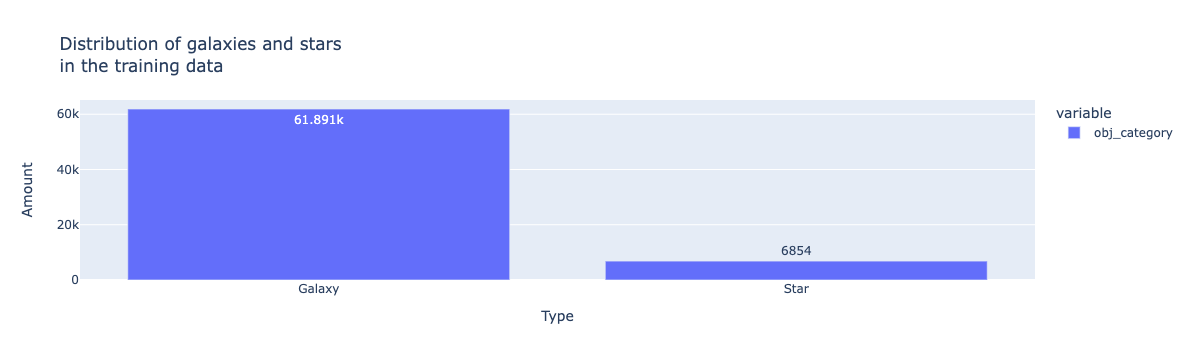

In [75]:
train_ps.obj_category.value_counts().plot.bar(title="Distribution of galaxies and stars <br>in the training data",
                                  text_auto=True,
                                 labels=dict(index="Type", value="Amount"))

In [17]:
train_ps[["modelMag_r"]].describe()

,modelMag_r
count,68745.000000
mean,17.396755
std,1.014964
min,14.000070
25%,16.861140
50%,17.401640
75%,17.768140
max,20.999570


Text(0.5, 1.0, 'Histogram of object magnitudes in the \nSDSS data sample')

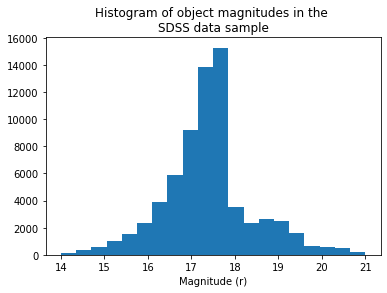

In [89]:
# Magnitude distribution
# Using matplotlib because of a known bug in which plotly
# does not display title, https://issues.apache.org/jira/browse/SPARK-37188
plt.hist(train_ps.modelMag_r, bins=20)
plt.xlabel("Magnitude (r)")
plt.title("Histogram of object magnitudes in the \nSDSS data sample")

In [79]:
# Calculate difference between psfMag and modelMag and create new column with results
train_ps["psfModelDiff"] = train_ps.psfMag_r-train_ps.modelMag_r

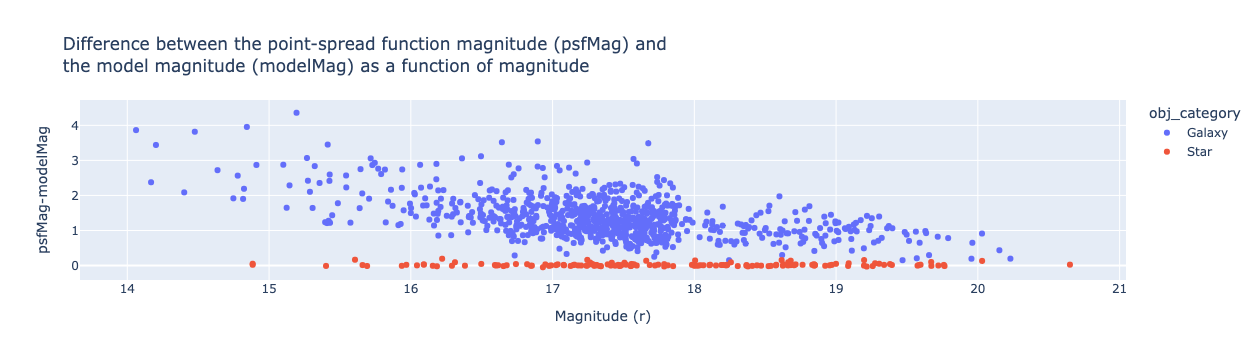

In [80]:
train_ps.plot.scatter(x='modelMag_r', y="psfModelDiff", color="obj_category",
                      title="Difference between the point-spread function magnitude (psfMag) and <br>the model magnitude (modelMag) as a function of magnitude",
                     labels=dict(modelMag_r="Magnitude (r)", psfModelDiff="psfMag-modelMag"))

## Modeling

### Random forest classifier

#### Set up transformations

In [38]:
from pyspark.ml.feature import SQLTransformer

sqlTrans = SQLTransformer(
    statement = "SELECT psfMag_r, modelMag_r, petroMag_r, fiberMag_r, \
                        petroRad_r, petroR50_r, petroR90_r, lnLStar_r, \
                        lnLExp_r, lnLDeV_r, mE1_r, mE2_r, mRrCc_r, \
                        type as label FROM __THIS__"
)

In [39]:
# Create our list of features by dropping unused columns
features_list = sqlTrans.transform(train).drop("label").columns
features_list

['psfMag_r',
 'modelMag_r',
 'petroMag_r',
 'fiberMag_r',
 'petroRad_r',
 'petroR50_r',
 'petroR90_r',
 'lnLStar_r',
 'lnLExp_r',
 'lnLDeV_r',
 'mE1_r',
 'mE2_r',
 'mRrCc_r']

We can set up transformations for our data.

In [40]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

assembler = VectorAssembler(inputCols=features_list, outputCol="features")

#scaler = StandardScaler(inputCol="unscaledFeatures", outputCol="features")

We can select an algorithm for our data and instantiate it.

In [41]:
from pyspark.ml.classification import RandomForestClassifier

rfc = RandomForestClassifier(labelCol="label", featuresCol="features")

Finally, we can set up a pipeline.

In [42]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages = [sqlTrans, assembler, rfc])

We can then set up cross-validation.

In [48]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator


rfcParamGrid = (ParamGridBuilder()
             .addGrid(rfc.maxDepth, [0, 10, 20, 30])
             .addGrid(rfc.numTrees, [5, 10, 20, 30, 40])
             .build())

crossVal = CrossValidator(estimator = pipeline,
                          estimatorParamMaps = rfcParamGrid,
                          evaluator = MulticlassClassificationEvaluator(),
                          numFolds = 3)

In [49]:
# Run cross-validation, and choose the best set of parameters

cvModel = crossVal.fit(train)

In [52]:
rfcPredictions = cvModel.transform(test)

In [59]:
print('Accuracy:', MulticlassClassificationEvaluator().evaluate(rfcPredictions))

Accuracy: 0.9960181108638269


In [60]:
from sklearn.metrics import confusion_matrix

y_pred=rfcPredictions.select("prediction").collect()
y_orig=rfcPredictions.select("label").collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[15603    24]
 [   45  1703]]


In [24]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression()
grid_lr = ParamGridBuilder().addGrid(lr.maxIter, [0, 1]).build()
evaluator_lr = MulticlassClassificationEvaluator()

In [26]:
pipeline_lr = Pipeline(stages = [sqlTrans, assembler, lr])

In [27]:
cv = CrossValidator(estimator=pipeline_lr, estimatorParamMaps=grid_lr, evaluator=evaluator_lr,
    parallelism=2)
cvModel_lr = cv.fit(train)

22/04/25 22:02:24 WARN CacheManager: Asked to cache already cached data.
22/04/25 22:02:24 WARN CacheManager: Asked to cache already cached data.


In [28]:
test_error = MulticlassClassificationEvaluator().evaluate(cvModel_lr.transform(test))
print(test_error)

0.940197424404984


In [49]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")
acc = evaluator.evaluate(pred)
print("Prediction Accuracy: ", acc)

Prediction Accuracy:  0.9951260086324447


In [60]:
faint_mag = pred.filter((pred.modelMag_r >= 20.5) & (pred.modelMag_r <= 21))

In [61]:
acc_faint = evaluator.evaluate(faint_mag)
print("Prediction Accuracy: ", acc_faint)

Prediction Accuracy:  0.9223043524303716


In [9]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
 
evaluator = BinaryClassificationEvaluator(
    labelCol="label",                     
    rawPredictionCol="prediction",       
    metricName="areaUnderROC",
)
 
accuracy = evaluator.evaluate(pred)
print(f"Area under ROC = {accuracy} ")

NameError: name 'pred' is not defined

## Decision tree

In [61]:
from pyspark.ml.classification import DecisionTreeClassifier

dtClassifier = DecisionTreeClassifier()

dtPipeline = Pipeline().setStages([sqlTrans, assembler, dtClassifier])

In [62]:
dtParamGrid = (ParamGridBuilder()
             .addGrid(dtClassifier.maxDepth, [0, 5, 10, 20]) \
             .build())

dtCrossVal = CrossValidator(estimator = dtPipeline,
                          estimatorParamMaps = dtParamGrid,
                          evaluator = MulticlassClassificationEvaluator(),
                          numFolds = 3)

In [63]:
# Run cross-validation, and choose the best set of parameters

dtCVModel = dtCrossVal.fit(train)

In [64]:
dtPredictions = dtCVModel.transform(test)

In [65]:
print('Accuracy:', MulticlassClassificationEvaluator().evaluate(dtPredictions))

Accuracy: 0.9937226278921604


### Gradient-boosted trees

In [81]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import GBTClassifier

stringIndexer = StringIndexer(inputCol="type",
                               outputCol="label",
                               handleInvalid="skip" )

gbtSQLTrans = SQLTransformer(
    statement = "SELECT psfMag_r, modelMag_r, petroMag_r, fiberMag_r, \
                        petroRad_r, petroR50_r, petroR90_r, lnLStar_r, \
                        lnLExp_r, lnLDeV_r, mE1_r, mE2_r, mRrCc_r, \
                        label FROM __THIS__"
)

gbtClassifier = GBTClassifier()

gbtPipeline = Pipeline().setStages([stringIndexer, gbtSQLTrans, assembler, gbt])

In [82]:
gbtParamGrid = (ParamGridBuilder()
             .addGrid(gbtClassifier.maxDepth, [0, 5, 10, 20]) \
             .build())

gbtCrossVal = CrossValidator(estimator = gbtPipeline,
                          estimatorParamMaps = gbtParamGrid,
                          evaluator = MulticlassClassificationEvaluator(),
                          numFolds = 3)

In [83]:
gbtCVModel = gbtCrossVal.fit(train)

In [84]:
gbtPredictions = gbtCVModel.transform(test)

In [88]:
gbtPredictions.show(5)

+--------+----------+----------+----------+----------+----------+----------+---------+----------+----------+----------+-----------+--------+-----+--------------------+--------------------+--------------------+----------+
|psfMag_r|modelMag_r|petroMag_r|fiberMag_r|petroRad_r|petroR50_r|petroR90_r|lnLStar_r|  lnLExp_r|  lnLDeV_r|     mE1_r|      mE2_r| mRrCc_r|label|            features|       rawPrediction|         probability|prediction|
+--------+----------+----------+----------+----------+----------+----------+---------+----------+----------+----------+-----------+--------+-----+--------------------+--------------------+--------------------+----------+
|18.70511|  16.89667|  16.91058|  18.57298|  5.902012|  2.750115|  5.684737|-11593.78| -422.4577| -1034.826| -0.305131| -0.1242297|51.97928|  0.0|[18.70511,16.8966...|[1.54261756354760...|[0.95627958330078...|       0.0|
|17.40547|  17.36561|  17.40621|  17.73569|  1.428235| 0.7082859|  1.609841|-26.98189|-0.8260614|-0.5565038|-0.16663

In [89]:
print('Accuracy:', MulticlassClassificationEvaluator().evaluate(gbtPredictions.filter(gbtPredictions.modelMag_r >= 20.5)))

Accuracy: 0.8769166317553414


In [95]:
 gbtPredictions.filter(gbtPredictions.modelMag_r >= 20.5).select(gbtPredictions.label, gbtPredictions.prediction).show(105)                                                                                                                                               

+-----+----------+
|label|prediction|
+-----+----------+
|  1.0|       0.0|
|  0.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  0.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|     

# References

<!-- BIBLIOGRAPHY START -->
<div class="csl-bib-body">
  <div class="csl-entry"><i id="zotero|6578788/Z75D4M6Y"></i><i>Sloan Digital Sky Surveys | SDSS</i>. (n.d.). Retrieved April 28, 2022, from <a href="https://www.sdss.org/surveys/">https://www.sdss.org/surveys/</a></div>
  <div class="csl-entry"><i id="zotero|6578788/UXVJ3YSM"></i>Vasconcellos, E. C., Carvalho, R. R. de, Gal, R. R., LaBarbera, F. L., Capelato, H. V., Velho, H. F. C., Trevisan, M., &#38; Ruiz, R. S. R. (2011). DECISION TREE CLASSIFIERS FOR STAR/GALAXY SEPARATION. <i>The Astronomical Journal</i>, <i>141</i>(6), 189. <a href="https://doi.org/10.1088/0004-6256/141/6/189">https://doi.org/10.1088/0004-6256/141/6/189</a></div>
</div>
<!-- BIBLIOGRAPHY END -->